In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import check_random_state
import jax.numpy as jnp

# create original signal

In [2]:
# params
nb_signals = 2
nb_freqs = 3
sr = 600
T = 1
random_state = 0
rng = check_random_state(random_state)
nb_subjects = 3
max_dilation = 1.2
max_shift = 40

In [3]:
def create_original_signals(nb_signals=3, nb_freqs=3, sr=100, T=6, rng=rng):
    def create_one_signal(nb_freqs=3, sr=100, T=6, rng=None):
        heights = rng.exponential(scale=1, size=nb_freqs)
        freq_max = 8
        frequencies = rng.choice(np.arange(1, freq_max), size=nb_freqs, replace=False)
        ts = 1.0 / sr
        t = np.arange(0, T, ts)
        s = np.zeros(sr * T)
        for i in range(nb_freqs):
            s += heights[i] * np.sin(2 * np.pi * frequencies[i] * t)
        return s
    S = np.vstack(
        [create_one_signal(nb_freqs=nb_freqs, sr=sr, T=T, rng=rng)
         for _ in range(nb_signals)])
    return S

S = create_original_signals(
    nb_signals=nb_signals, nb_freqs=nb_freqs, sr=sr, T=T, rng=rng)
S_list = np.array([S] * nb_subjects)

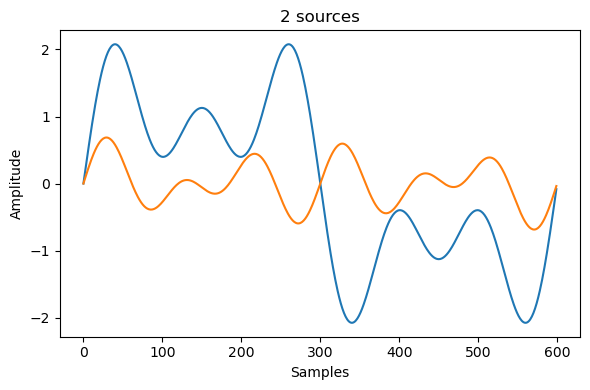

In [4]:
# plot S
plt.figure(figsize=(6, 4))
plt.plot(S.T)
plt.title(f"{nb_signals} sources")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

# apply delay function

In [5]:
def apply_both_delays_1d(s, a=1, b=0, t0=0):
    t = jnp.arange(len(s)) - t0
    t_ab = (t - b) * a  
    # by writing (t-b)*a instead of t*a-b we allow the constant delay to be measurable in sample, 
    # i.e. constant_delay=5 means 5 samples, which corresponds to 5ms if the sampling rate is 1000Hz. 
    # It also means that we apply constant delay before cumulative delay, contrary to the paper on age-related delay.
    s_ab = jnp.interp(x=t_ab, xp=t, fp=s, left=0, right=0)
    return s_ab

In [6]:
def apply_both_delays_2d(S, a=None, b=None, t0=0):
    p, n = S.shape
    if a is None:
        a = jnp.ones(p)
    if b is None:
        b = jnp.zeros(p)
    t = jnp.arange(n) - t0
    T = jnp.array([t] * p)
    T_ab = ((T.T - b) * a).T
    S_ab = jnp.array([jnp.interp(x=T_ab[i], xp=t, fp=S[i], left=0, right=0) for i in range(p)])
    return S_ab

In [7]:
def apply_both_delays_3d(S_list, A=None, B=None, t0=0):
    Y_list = jnp.array([apply_both_delays_2d(S_list[i], a=A[i], b=B[i], t0=t0) for i in range(len(S_list))])
    return Y_list

# plot

In [8]:
A = rng.uniform(low=1/max_dilation, high=max_dilation, size=(nb_subjects, nb_signals))
B = rng.uniform(low=-max_shift, high=max_shift, size=(nb_subjects, nb_signals))
t0 = sr / 3

Y_list = apply_both_delays_3d(S_list, A=A, B=B, t0=t0)

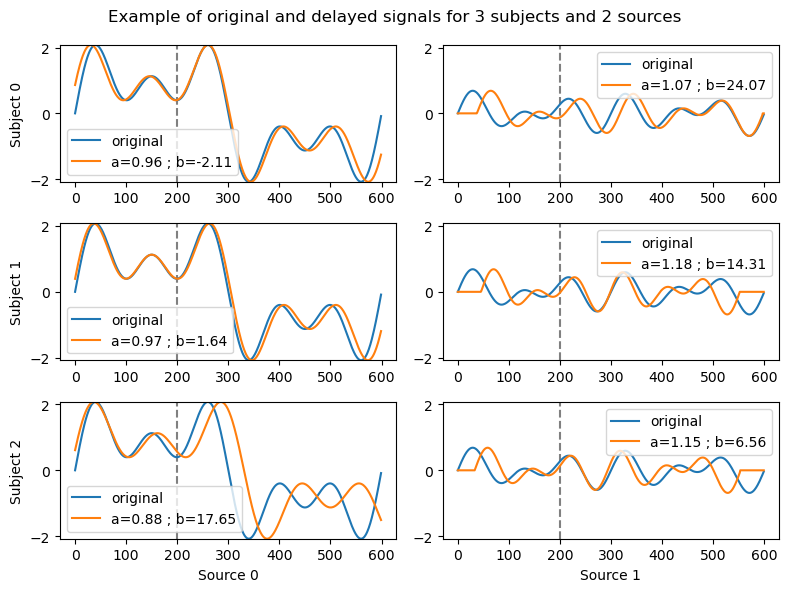

In [9]:
# plot
plt.subplots(nb_subjects, nb_signals, figsize=(4*nb_signals, 2*nb_subjects))

for i in range(nb_subjects):
    for j in range(nb_signals):
        plt.subplot(nb_subjects, nb_signals, nb_signals * i + j + 1)
        plt.plot(S_list[i, j], label='original')
        plt.plot(Y_list[i, j], label=f'a={A[i, j]:.2f} ; b={B[i, j]:.2f}')
        plt.vlines(x=t0, ymin=np.min(S_list), ymax=np.max(S_list), linestyles='--', colors='grey')
        plt.ylim([np.min(S_list), np.max(S_list)])
        if j == 0:
            plt.ylabel(f"Subject {i}")
        if i == nb_subjects - 1:
            plt.xlabel(f"Source {j}")
        plt.legend()
plt.suptitle(f"Example of original and delayed signals for {nb_subjects} subjects and {nb_signals} sources")
plt.tight_layout()
plt.show()

# check if apply_both_delays_3d(S_list, A=1/dilations, B=-shifts, t0=t0) gives back the original signals

In [10]:
S_list_back = apply_both_delays_3d(Y_list, A=1/A, B=-B, t0=t0)

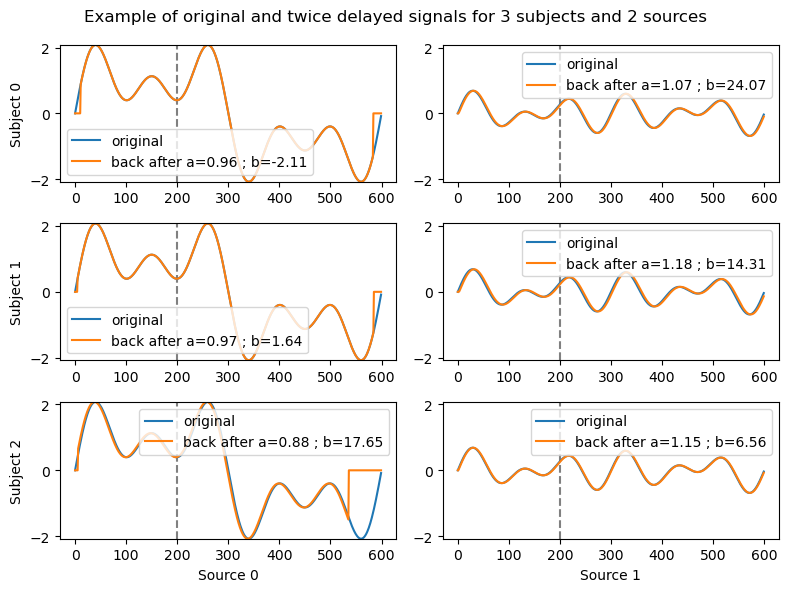

In [11]:
# plot
plt.subplots(nb_subjects, nb_signals, figsize=(4*nb_signals, 2*nb_subjects))

for i in range(nb_subjects):
    for j in range(nb_signals):
        plt.subplot(nb_subjects, nb_signals, nb_signals * i + j + 1)
        plt.plot(S_list[i, j], label='original')
        plt.plot(S_list_back[i, j], label=f'back after a={A[i, j]:.2f} ; b={B[i, j]:.2f}')
        plt.vlines(x=t0, ymin=np.min(S_list), ymax=np.max(S_list), linestyles='--', colors='grey')
        plt.ylim([np.min(S_list), np.max(S_list)])
        # plt.xlim([100, 200])
        if j == 0:
            plt.ylabel(f"Subject {i}")
        if i == nb_subjects - 1:
            plt.xlabel(f"Source {j}")
        plt.legend()
plt.suptitle(f"Example of original and twice delayed signals for {nb_subjects} subjects and {nb_signals} sources")
plt.tight_layout()
plt.show()

# gradient descent

In [12]:
import jax

In [13]:
def loss(a_b, s1, s2):
    a, b = a_b
    s2_d = apply_both_delays_1d(s2, a=a, b=b)
    return jnp.mean((s1 - s2_d) ** 2)

grad = jax.grad(loss)

In [14]:
s2 = S[0]
s1 = apply_both_delays_1d(s2, a=1.1, b=10)

alpha = 0.1
n_iter = 100
a = 1.
b = 0.
for i in range(n_iter):
    ga, gb = grad((a, b), s1, s2)
    a = a - alpha * ga
    b = b - alpha * gb
    print(a, b)

2.184722 -0.002709121
2.1595306 -0.0012300708
2.1111298 0.00044857222
2.0178804 0.002480174
1.8400575 0.0050475216
1.6494807 0.007282299
1.7646462 0.0074910102
1.6757169 0.008942544
1.7527139 0.009360125
1.6886542 0.010646699
1.7441009 0.011191038
1.6928372 0.012389524
1.7417804 0.012973311
1.7000087 0.014116007
1.7313126 0.014802393
1.709497 0.015819041
1.7237854 0.016603975
1.7116764 0.017553926
1.7269905 0.018339498
1.7128091 0.019304754
1.7233369 0.020117048
1.7129611 0.021056658
1.7234 0.02186877
1.7125763 0.022811431
1.7245407 0.02361492
1.7090083 0.024583245
1.725316 0.025357535
1.707227 0.026338382
1.7300001 0.02707833
1.7034999 0.028114192
1.7312804 0.02882172
1.6995924 0.029887374
1.7330077 0.030559357
1.7048862 0.03161097
1.7274308 0.032347687
1.7110195 0.03332775
1.7195088 0.034143575
1.7146894 0.035044905
1.719206 0.03588976
1.7152752 0.036786333
1.7161477 0.037656143
1.7147095 0.038533453
1.7191092 0.039379295
1.7158026 0.04027329
1.7158711 0.041141633
1.7149539 0.0420170

In [34]:
def loss(a, s1, s2):
    s2_d = apply_both_delays_1d(s2, a=a, b=0)
    return jnp.mean((s1 - s2_d) ** 2)

grad = jax.grad(loss)

s2 = S[0]
s1 = apply_both_delays_1d(s2, a=1.1, b=0.)

alpha = 0.001
n_iter = 100
a = 1.
for i in range(n_iter):
    ga = grad(a, s1, s2)
    a = a - alpha * ga
    print(a)

1.01232
1.0246505
1.0369436
1.0486536
1.0592474
1.068338
1.0758053
1.0817282
1.0863069
1.0897985
1.0924222
1.0943877
1.0958499
1.0969313
1.0977379
1.098328
1.098768
1.099095
1.099325
1.0994967
1.099625
1.0997207
1.099792
1.0998452
1.0998847
1.0999142
1.0999361
1.0999525
1.0999646
1.0999737
1.0999805
1.0999855
1.0999892
1.0999919
1.099994
1.0999955
1.0999967
1.0999975
1.0999981
1.0999986
1.099999
1.0999992
1.0999994
1.0999995
1.0999997
1.0999998
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999


# boundary conditions

In [24]:
def apply_both_delays_1d_cyclic(s, a=1, b=0, t0=0):
    n = len(s)
    max_delay = int(np.ceil((n + max_shift) * max_dilation) - n)
    s_concat = np.concatenate([s[n-max_delay:], s, s[:max_delay]])
    t_concat = np.arange(len(s_concat)) - max_delay - t0
    t = jnp.arange(len(s)) - t0
    t_ab = (t - b) * a
    s_ab = jnp.interp(x=t_ab, xp=t_concat, fp=s_concat)
    return s_ab

def apply_both_delays_2d_cyclic(S, a=None, b=None, t0=0):
    p, n = S.shape
    max_delay = int(np.ceil((n + max_shift) * max_dilation) - n)
    if a is None:
        a = jnp.ones(p)
    if b is None:
        b = jnp.zeros(p)
        
    S_concat = np.concatenate([S[:, n-max_delay:], S, S[:, :max_delay]], axis=1)
    t_concat = np.arange(S_concat.shape[1]) - max_delay - t0

    t = jnp.arange(n) - t0
    T = jnp.array([t] * p)
    T_ab = ((T.T - b) * a).T
    S_ab = jnp.array(
        [jnp.interp(x=T_ab[i], xp=t_concat, fp=S_concat[i], left=0, right=0)
         for i in range(p)])
    return S_ab

def apply_both_delays_3d_cyclic(S_list, A=None, B=None, t0=0):
    Y_list = jnp.array([apply_both_delays_2d_cyclic(S_list[i], a=A[i], b=B[i], t0=t0) for i in range(len(S_list))])
    return Y_list

In [25]:
Y_list_2 = apply_both_delays_3d_cyclic(S_list, A=A, B=B, t0=t0)

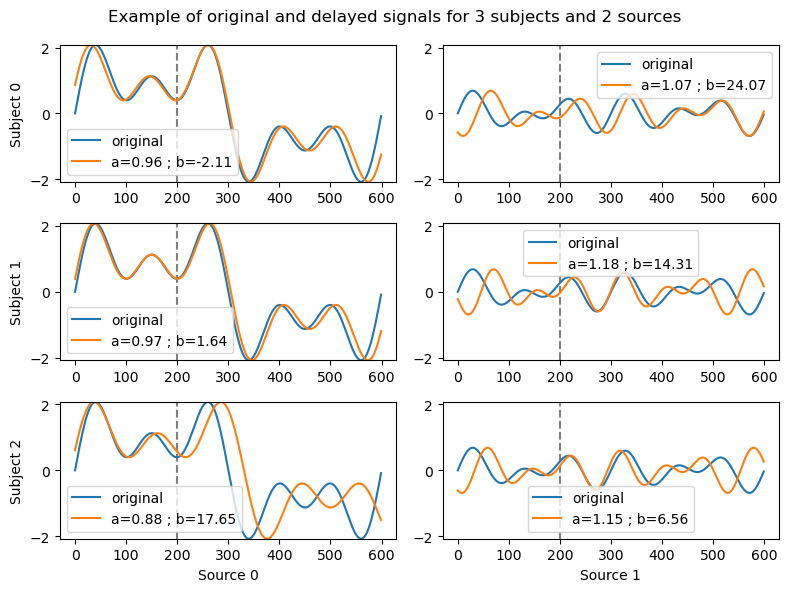

In [26]:
# plot
plt.subplots(nb_subjects, nb_signals, figsize=(4*nb_signals, 2*nb_subjects))

for i in range(nb_subjects):
    for j in range(nb_signals):
        plt.subplot(nb_subjects, nb_signals, nb_signals * i + j + 1)
        plt.plot(S_list[i, j], label='original')
        plt.plot(Y_list_2[i, j], label=f'a={A[i, j]:.2f} ; b={B[i, j]:.2f}')
        plt.vlines(x=t0, ymin=np.min(S_list), ymax=np.max(S_list), linestyles='--', colors='grey')
        plt.ylim([np.min(S_list), np.max(S_list)])
        if j == 0:
            plt.ylabel(f"Subject {i}")
        if i == nb_subjects - 1:
            plt.xlabel(f"Source {j}")
        plt.legend()
plt.suptitle(f"Example of original and delayed signals for {nb_subjects} subjects and {nb_signals} sources")
plt.tight_layout()
plt.show()

No more flat lines.